In [50]:
from sklearn.model_selection import train_test_split
from apscheduler.schedulers.background import BackgroundScheduler
from apscheduler.schedulers.blocking import BlockingScheduler
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client import InfluxDBClient
from dotenv import load_dotenv
import pandas as pd
import datetime
import requests
import joblib
import os

### 데이터 수집

In [51]:
# InfluxDB 접속 정보 불러오기
load_dotenv('secret.env')

DB_URL=os.getenv('DB_URL')
DB_TOKEN=os.getenv('DB_TOKEN')
DB_ORG=os.getenv('DB_ORG')
DB_BUCKET=os.getenv('DB_BUCKET')

In [52]:
# InfluxDB에서 주어진 측정치에 대한 데이터를 조회하여 DataFrame으로 반환.
def query_influx(measurement, place):
    client = InfluxDBClient(url=DB_URL, token=DB_TOKEN, org=DB_ORG, timeout=30_000)
    query_api = client.query_api()
    
    query = f'''
    import "date"
    import "experimental/query"
    from(bucket: "{DB_BUCKET}")
    |> range(start: date.sub(d: 7d, from: date.truncate(t: now(), unit: 1d)), stop: now())
    |> filter(fn: (r) => r["_measurement"] == "{measurement}")
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    |> filter(fn: (r) => r.place == "{place}")
    '''
    
    result_df = query_api.query_data_frame(org=DB_ORG, query=query)
    print(f"{place} {measurement} shape: ", result_df.shape)
    
    client.close()
    return result_df

outdoor_temperature_df = query_influx("temperature", "outdoor")
outdoor_humidity_df = query_influx("humidity", "outdoor")
temperature_df = query_influx("temperature", "class_a")
humidity_df = query_influx("humidity", "class_a")
people_count_df = query_influx("total_people_count", "class_a")
magnet_status_df = query_influx("magnet_status", "class_a")


outdoor temperature shape:  (40, 10)
outdoor humidity shape:  (40, 10)
class_a temperature shape:  (17445, 10)
class_a humidity shape:  (17447, 10)
class_a total_people_count shape:  (11173, 10)
class_a magnet_status shape:  (654, 10)


### 데이터 전처리

In [53]:
# 필요없는 컬럼 삭제 및 한국시간으로 시간대 변환
def clean_and_convert_time(df):
    df = df.drop(columns=['_start', '_stop', 'result', 'table', 'topic', 'device'])
    df['_time'] = pd.to_datetime(df['_time']).dt.tz_convert('Asia/Seoul').dt.tz_localize(None)
    
    return df


temperature_outdoor_df = clean_and_convert_time(outdoor_temperature_df)
humidity_outdoor_df = clean_and_convert_time(outdoor_humidity_df)
temperature_class_a_df = clean_and_convert_time(temperature_df)
humidity_class_a_df = clean_and_convert_time(humidity_df)
people_count_df = clean_and_convert_time(people_count_df)
magnet_status_df = clean_and_convert_time(magnet_status_df)

In [54]:
print("info : ", temperature_outdoor_df.head(), '\n')
print("info : ", humidity_outdoor_df.head(), '\n')
print("info : ", temperature_class_a_df.head(), '\n')
print("info : ", humidity_class_a_df.head(), '\n')
print("info : ", people_count_df.head(), '\n')
print("info : ", magnet_status_df.head(), '\n')

info :                         _time _measurement    place  value
0 2024-04-23 17:38:10.170493  temperature  outdoor   18.6
1 2024-04-23 17:48:10.570783  temperature  outdoor   18.5
2 2024-04-23 17:58:09.953316  temperature  outdoor   18.4
3 2024-04-23 18:08:10.380200  temperature  outdoor   18.4
4 2024-04-23 18:18:10.775806  temperature  outdoor   18.4 

info :                         _time _measurement    place  value
0 2024-04-23 17:38:10.183036     humidity  outdoor   53.5
1 2024-04-23 17:48:10.583670     humidity  outdoor   54.0
2 2024-04-23 17:58:09.966480     humidity  outdoor   54.0
3 2024-04-23 18:08:10.393524     humidity  outdoor   54.5
4 2024-04-23 18:18:10.788553     humidity  outdoor   55.0 

info :                         _time _measurement    place      value
0 2024-04-19 14:43:51.540435  temperature  class_a  24.299999
1 2024-04-19 14:45:25.074113  temperature  class_a  23.400000
2 2024-04-19 14:45:49.959823  temperature  class_a  24.400000
3 2024-04-19 14:46:10.411416

In [55]:
# resample로 1분단위로 데이터를 합치기 위해 Datetime을 인덱스로 지정
# value에 대해 1분 단위로 평균 or 마지막값 계산. resample을 수행한 후에는 Series 객체가 됨.
def resample_data(df, column, freq, method):
    df = df.set_index('_time')

    if method == 'mean':
        return df[column].resample(freq).mean()
    elif method == 'last':
        return df[column].resample(freq).last()

outdoor_temperature_summary_series = resample_data(temperature_outdoor_df, 'value', 'T', 'mean')
outdoor_humidity_summary_series = resample_data(humidity_outdoor_df, 'value', 'T', 'mean')
temperature_summary_series = resample_data(temperature_class_a_df, 'value', 'T', 'mean')
humidity_summary_series = resample_data(humidity_class_a_df, 'value', 'T', 'mean')
people_count_series = resample_data(people_count_df, 'value', 'T', 'last')
magnet_status_series = resample_data(magnet_status_df, 'value', 'T', 'last')

print(outdoor_temperature_summary_series.head(),'\n', outdoor_humidity_summary_series.head(),'\n', temperature_summary_series.head(),'\n', humidity_summary_series.head(),'\n', people_count_series.head(),'\n',magnet_status_series.head(),'\n')

_time
2024-04-23 17:38:00    18.6
2024-04-23 17:39:00     NaN
2024-04-23 17:40:00     NaN
2024-04-23 17:41:00     NaN
2024-04-23 17:42:00     NaN
Freq: T, Name: value, dtype: float64 
 _time
2024-04-23 17:38:00    53.5
2024-04-23 17:39:00     NaN
2024-04-23 17:40:00     NaN
2024-04-23 17:41:00     NaN
2024-04-23 17:42:00     NaN
Freq: T, Name: value, dtype: float64 
 _time
2024-04-19 14:43:00    24.299999
2024-04-19 14:44:00          NaN
2024-04-19 14:45:00    23.900000
2024-04-19 14:46:00    24.300000
2024-04-19 14:47:00    24.080000
Freq: T, Name: value, dtype: float64 
 _time
2024-04-19 14:43:00    42.5
2024-04-19 14:44:00     NaN
2024-04-19 14:45:00    46.0
2024-04-19 14:46:00    44.0
2024-04-19 14:47:00    45.3
Freq: T, Name: value, dtype: float64 
 _time
2024-04-19 14:43:00    9.0
2024-04-19 14:44:00    NaN
2024-04-19 14:45:00    7.0
2024-04-19 14:46:00    9.0
2024-04-19 14:47:00    9.0
Freq: T, Name: value, dtype: float64 
 _time
2024-04-19 14:49:00    open
2024-04-19 14:50:00  

In [56]:
data_df = pd.DataFrame({
    'outdoor_temperature': outdoor_temperature_summary_series,
    'outdoor_humidity': outdoor_humidity_summary_series,
    'temperature': temperature_summary_series,
    'humidity': humidity_summary_series,
    'people_count': people_count_series,
    'air_conditional': magnet_status_series
})

print(data_df)

                     outdoor_temperature  outdoor_humidity  temperature  \
_time                                                                     
2024-04-19 14:43:00                  NaN               NaN    24.299999   
2024-04-19 14:44:00                  NaN               NaN          NaN   
2024-04-19 14:45:00                  NaN               NaN    23.900000   
2024-04-19 14:46:00                  NaN               NaN    24.300000   
2024-04-19 14:47:00                  NaN               NaN    24.080000   
...                                  ...               ...          ...   
2024-04-24 00:04:00                  NaN               NaN    22.750000   
2024-04-24 00:05:00                  NaN               NaN    22.233334   
2024-04-24 00:06:00                  NaN               NaN    22.750000   
2024-04-24 00:07:00                  NaN               NaN    22.200000   
2024-04-24 00:08:00            16.200001              69.0    22.299999   

                      hu

In [57]:
null_values = data_df.isnull().sum()
print('Initial null value:\n', null_values)

# 'air_conditional' 컬럼의 첫 번째 값이 결측치인 경우 'close'로 설정
if pd.isna(data_df.loc[data_df.index[0], 'air_conditional']):
    data_df.at[data_df.index[0], 'air_conditional'] = 'close'

if pd.isna(data_df.loc[data_df.index[0], 'outdoor_temperature']):
    avg_temperature = data_df['outdoor_temperature'].mean()
    data_df.at[data_df.index[0], 'outdoor_temperature'] = avg_temperature

if pd.isna(data_df.loc[data_df.index[0], 'outdoor_humidity']):
    avg_humidity = data_df['outdoor_humidity'].mean()
    data_df.at[data_df.index[0], 'outdoor_humidity'] = avg_humidity

# people_count' 컬럼에서 첫 번째 값이 결측치인 경우, 최근 유효 값으로 채우기
if pd.isna(data_df.loc[data_df.index[0], 'people_count']):
    notnull_peoplecount = data_df[data_df['people_count'].notnull()].iloc[0]['people_count']
    data_df.at[data_df.index[0], 'people_count'] = notnull_peoplecount

# 나머지 결측치 전방 채우기
data_df_filled = data_df.fillna(method='ffill', axis=0)

print('After processing null value: \n', data_df_filled.isnull().sum())

Initial null value:
 outdoor_temperature    6286
outdoor_humidity       6286
temperature              10
humidity                 10
people_count             55
air_conditional        5688
dtype: int64
After processing null value: 
 outdoor_temperature    0
outdoor_humidity       0
temperature            0
humidity               0
people_count           0
air_conditional        0
dtype: int64


In [58]:
print(data_df_filled)
print(data_df_filled.shape)

                     outdoor_temperature  outdoor_humidity  temperature  \
_time                                                                     
2024-04-19 14:43:00            17.090000           66.1375    24.299999   
2024-04-19 14:44:00            17.090000           66.1375    24.299999   
2024-04-19 14:45:00            17.090000           66.1375    23.900000   
2024-04-19 14:46:00            17.090000           66.1375    24.300000   
2024-04-19 14:47:00            17.090000           66.1375    24.080000   
...                                  ...               ...          ...   
2024-04-24 00:04:00            16.100000           70.5000    22.750000   
2024-04-24 00:05:00            16.100000           70.5000    22.233334   
2024-04-24 00:06:00            16.100000           70.5000    22.750000   
2024-04-24 00:07:00            16.100000           70.5000    22.200000   
2024-04-24 00:08:00            16.200001           69.0000    22.299999   

                      hu

In [59]:
# 날짜값 제거
data_df_filled.index = data_df_filled.index.time
print(data_df_filled.head())

          outdoor_temperature  outdoor_humidity  temperature  humidity  \
14:43:00                17.09           66.1375    24.299999      42.5   
14:44:00                17.09           66.1375    24.299999      42.5   
14:45:00                17.09           66.1375    23.900000      46.0   
14:46:00                17.09           66.1375    24.300000      44.0   
14:47:00                17.09           66.1375    24.080000      45.3   

          people_count air_conditional  
14:43:00           9.0           close  
14:44:00           9.0           close  
14:45:00           7.0           close  
14:46:00           9.0           close  
14:47:00           9.0           close  


In [60]:
# air_conditional의 값이 close면 0, open이면 1로 변경
data_df_filled['air_conditional'] = data_df_filled['air_conditional'].map({'close': 0, 'open': 1})

print(data_df_filled.head())
print(data_df_filled.info)

          outdoor_temperature  outdoor_humidity  temperature  humidity  \
14:43:00                17.09           66.1375    24.299999      42.5   
14:44:00                17.09           66.1375    24.299999      42.5   
14:45:00                17.09           66.1375    23.900000      46.0   
14:46:00                17.09           66.1375    24.300000      44.0   
14:47:00                17.09           66.1375    24.080000      45.3   

          people_count  air_conditional  
14:43:00           9.0                0  
14:44:00           9.0                0  
14:45:00           7.0                0  
14:46:00           9.0                0  
14:47:00           9.0                0  
<bound method DataFrame.info of           outdoor_temperature  outdoor_humidity  temperature   humidity  \
14:43:00            17.090000           66.1375    24.299999  42.500000   
14:44:00            17.090000           66.1375    24.299999  42.500000   
14:45:00            17.090000           66.137

In [61]:
# 상관계수 계산
correlation_matrix = data_df_filled.corr()
print(correlation_matrix)

                     outdoor_temperature  outdoor_humidity  temperature  \
outdoor_temperature             1.000000         -0.894860     0.129207   
outdoor_humidity               -0.894860          1.000000    -0.130743   
temperature                     0.129207         -0.130743     1.000000   
humidity                       -0.044932          0.037380     0.235994   
people_count                    0.055447         -0.054358     0.251042   
air_conditional                 0.011044         -0.003908    -0.309783   

                     humidity  people_count  air_conditional  
outdoor_temperature -0.044932      0.055447         0.011044  
outdoor_humidity     0.037380     -0.054358        -0.003908  
temperature          0.235994      0.251042        -0.309783  
humidity             1.000000     -0.016200        -0.007261  
people_count        -0.016200      1.000000         0.349802  
air_conditional     -0.007261      0.349802         1.000000  


### 데이터 시각화

/home/gahyoung/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


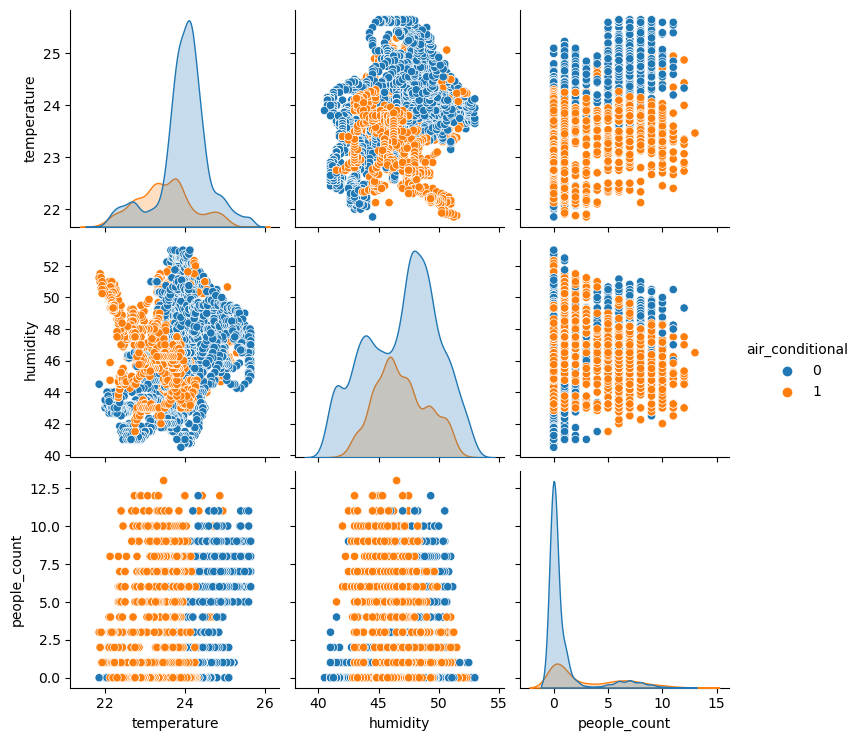

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# 산점도 그리기
sns.pairplot(data_df_filled, hue='air_conditional', vars=['temperature', 'humidity', 'people_count'])
plt.show()

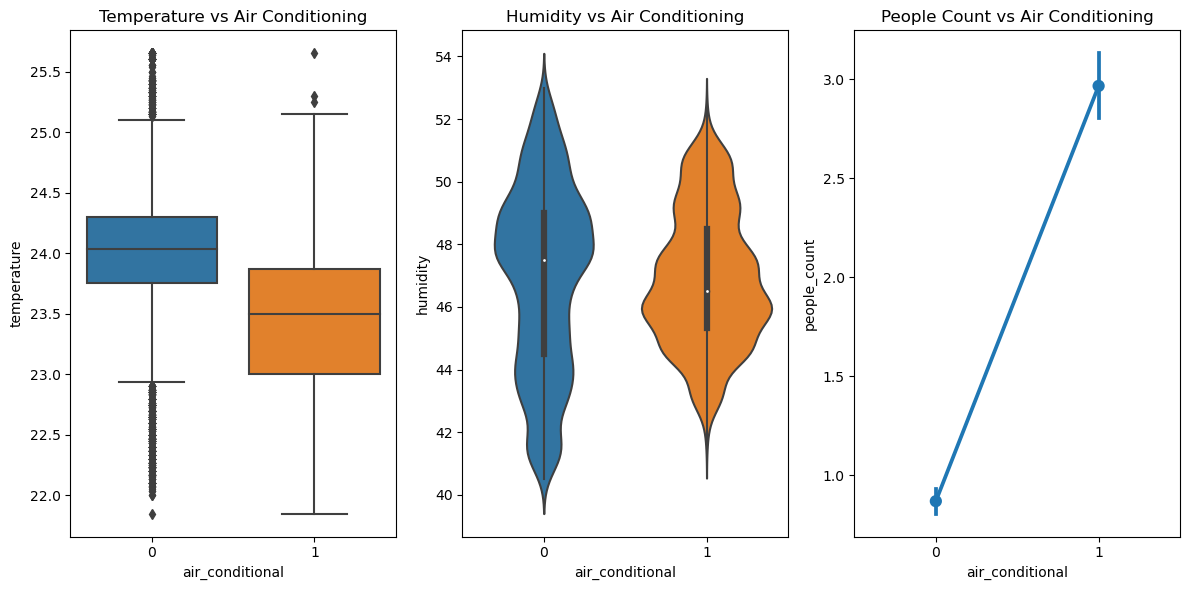

In [63]:

# 데이터 세트 설정
data = data_df_filled  # 데이터 프레임 이름을 'data_df_filled'에서 'data'로 변경했습니다.

# 1. 온도와 에어컨의 상관관계 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x='air_conditional', y='temperature', data=data)
plt.title('Temperature vs Air Conditioning')

# 2. 습도와 에어컨의 상관관계 시각화
plt.subplot(1, 3, 2)
sns.violinplot(x='air_conditional', y='humidity', data=data)
plt.title('Humidity vs Air Conditioning')

# 3. 재실 인원과 에어컨의 상관관계 시각화
plt.subplot(1, 3, 3)
sns.pointplot(x='air_conditional', y='people_count', data=data)
plt.title('People Count vs Air Conditioning')

plt.tight_layout()
plt.show()


### 모델링
1. 데이터 분할

In [64]:
# 훈련데이터와 테스트 데이터 분리
X = data_df_filled[['temperature', 'humidity', 'people_count']]
y = data_df_filled['air_conditional']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2. 모델 훈련 및 평가

In [65]:
# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 데이터 준비: X는 온도와 습도, y는 에어컨의 ON/OFF 상태
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

# 모델 평가
from sklearn.metrics import accuracy_score
log_reg_predictions = log_reg_model.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)

In [66]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 성능 평가
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

In [67]:
# XG 부스트
import xgboost as xgb

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 생성 및 학습
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

# 예측 및 성능 평가
xgboost_predictions = xgboost_model.predict(X_test)
xgboost_accuracy = accuracy_score(y_test, xgboost_predictions)

In [68]:
print("LogisticRegression Accuracy:", log_reg_accuracy)
print("RandomForest Accuracy:", rf_accuracy)
print("XGBoost Accuracy:", xgboost_accuracy)

LogisticRegression Accuracy: 0.7898894154818326
RandomForest Accuracy: 0.9328593996840442
XGBoost Accuracy: 0.9304897314375987


In [69]:
print(y.value_counts())

0    4618
1    1708
Name: air_conditional, dtype: int64


In [70]:
from sklearn.metrics import classification_report

print(classification_report(y_test, log_reg_predictions))
print(classification_report(y_test, rf_predictions))
print(classification_report(y_test, xgboost_predictions))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       921
           1       0.67      0.46      0.54       345

    accuracy                           0.79      1266
   macro avg       0.74      0.69      0.70      1266
weighted avg       0.78      0.79      0.78      1266

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       921
           1       0.88      0.88      0.88       345

    accuracy                           0.93      1266
   macro avg       0.92      0.91      0.92      1266
weighted avg       0.93      0.93      0.93      1266

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       921
           1       0.89      0.85      0.87       345

    accuracy                           0.93      1266
   macro avg       0.92      0.91      0.91      1266
weighted avg       0.93      0.93      0.93      1266



3. 모델 선택

In [71]:
# 모델 저장 경로와 파일 이름 설정
MODEL_NAME = 'air_conditional_ai_model.joblib'
MODEL_PATH = './' 

# 모델 저장
joblib.dump(rf_model, MODEL_PATH + MODEL_NAME)

['./air_conditional_ai_model.joblib']

### NHN Cloud Object Storage에 모델 업로드

In [72]:
class ObjectService:
    def __init__(self, storage_url, token_id):
        self.storage_url = storage_url
        self.token_id = token_id

    def _get_url(self, container, object):
        return '/'.join([self.storage_url, container, object])

    def _get_request_header(self):
        return {'X-Auth-Token': self.token_id}

    def upload(self, container, object, object_path):
        req_url = self._get_url(container, object)
        req_header = self._get_request_header()

        path = '/'.join([object_path, object])
        with open(path, 'rb') as f:
            return requests.put(req_url, headers=req_header, data=f.read())


if __name__ == '__main__':

    STORAGE_URL = os.getenv('STORAGE_URL')
    ACCESS_TOKEN_ID = os.getenv('ACCESS_TOKEN_ID')
    CONTAINER_NAME = os.getenv('CONTAINER_NAME')
    OBJECT_PATH = '.' 
    
    obj_service = ObjectService(STORAGE_URL, ACCESS_TOKEN_ID)

    obj_service.upload(CONTAINER_NAME, MODEL_NAME, OBJECT_PATH)